<link href="https://fonts.googleapis.com/css2?family=Inter:wght@400&display=swap" rel="stylesheet">
<div style="font-family: 'Inter'; font-size: 24px; color: #749857;"><B>🍏 Show Up</b> for Health</div>
<div style="font-family: 'Inter'; font-size: 14px; color: #7a7979;"><B>Predicting Missed Apppointment in Primary Care</b> - Brompton Health PCN</div>

[janduplessis883](https://github.com/janduplessis883)<BR>
[AlexAlexRose](https://github.com/AlexAlexRose)<BR>
[FabySp](https://github.com/FabySp)<BR>
[mogleyza](https://github.com/mogleyza)

# GitHub Username | Notebook Title 

### Importing Libraries

In [10]:
# Importing default Libraries
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns
import warnings

#import re for text identifier
import re
from datetime import datetime
import seaborn as sns


# Hi-resolution Plots and Matplotlib inline
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Set the maximum number of rows and columns to be displayed
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000
warnings.filterwarnings('ignore')

# "magic commands" to enable autoreload of your imported packages
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Params

In [17]:
RAW_DATA = '~/code/janduplessis883/data-showup/data/raw-data/'
WEATHER_DATA = '~/code/janduplessis883/data-showup/data/weather/weather.csv'
IMD_DATA = '~/code/janduplessis883/data-showup/data/imd-master/imd_master.csv'

OUTPUT_DATA = '~/code/janduplessis883/data-showup/data/output-data/'


#this link will need to be updated
ecs =pd.read_csv('~/code/janduplessis883/project-showupforhealth/data-showup/data/raw-data/ECS/ECS_CLINICAL.csv')
tdata = pd.read_csv('~/code/janduplessis883/project-showupforhealth/data-showup/data/output-data/training_data_no_features.csv')
print(tdata['Registration status'].describe())

count     1026757
unique          4
top       Current
freq       908518
Name: Registration status, dtype: object


In [15]:
#Boolean mask - drop all rows that aren't current patients

def filter_current_registration(data):
    # Filter rows where 'Registration status' is 'Current'
    data = data[data['Registration status'] == 'Current']
    
    return data

# Call the function to filter rows with 'Registration status' as 'Current'
tdata = filter_current_registration(tdata)

count    908192.000000
mean          4.093470
std           6.846261
min           0.000000
25%           0.000000
50%           1.000000
75%           7.000000
max         305.000000
Name: Days Difference, dtype: float64


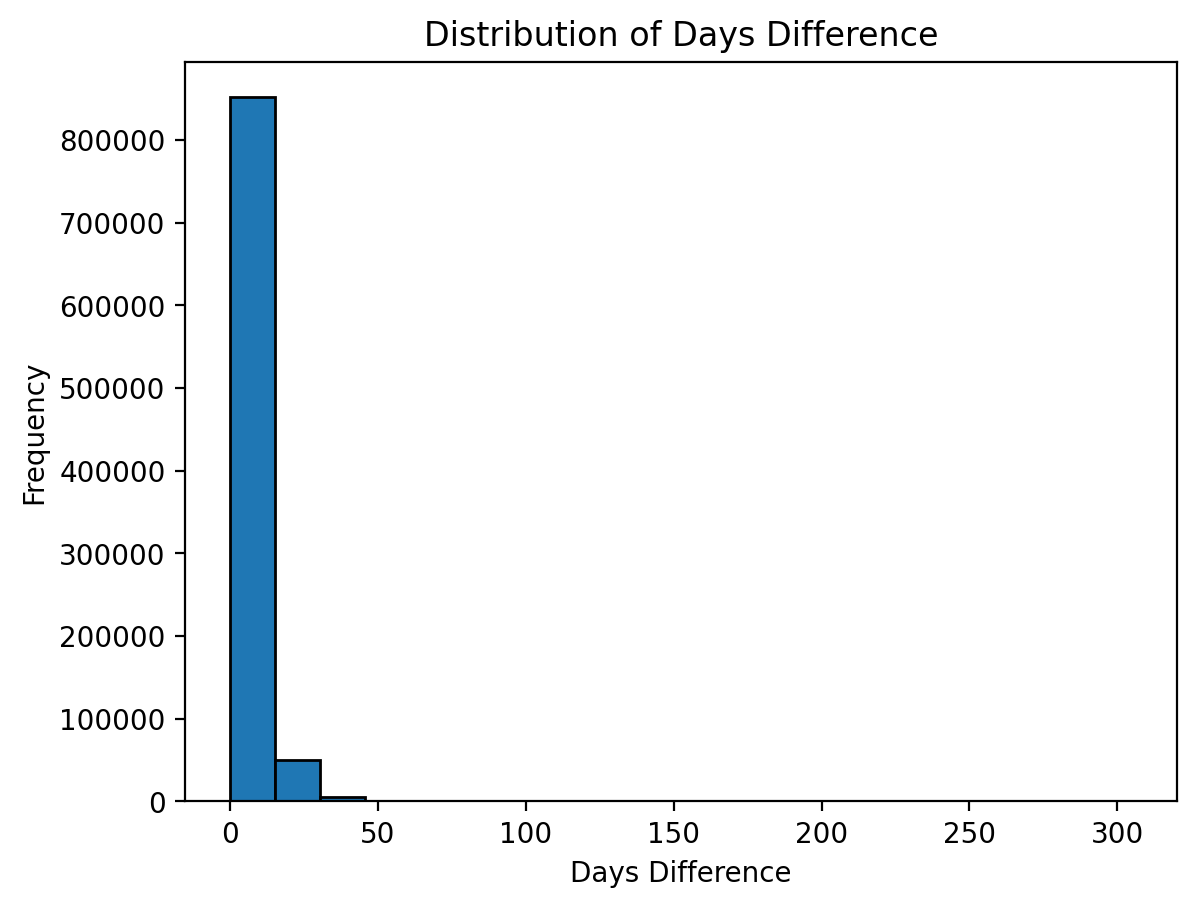

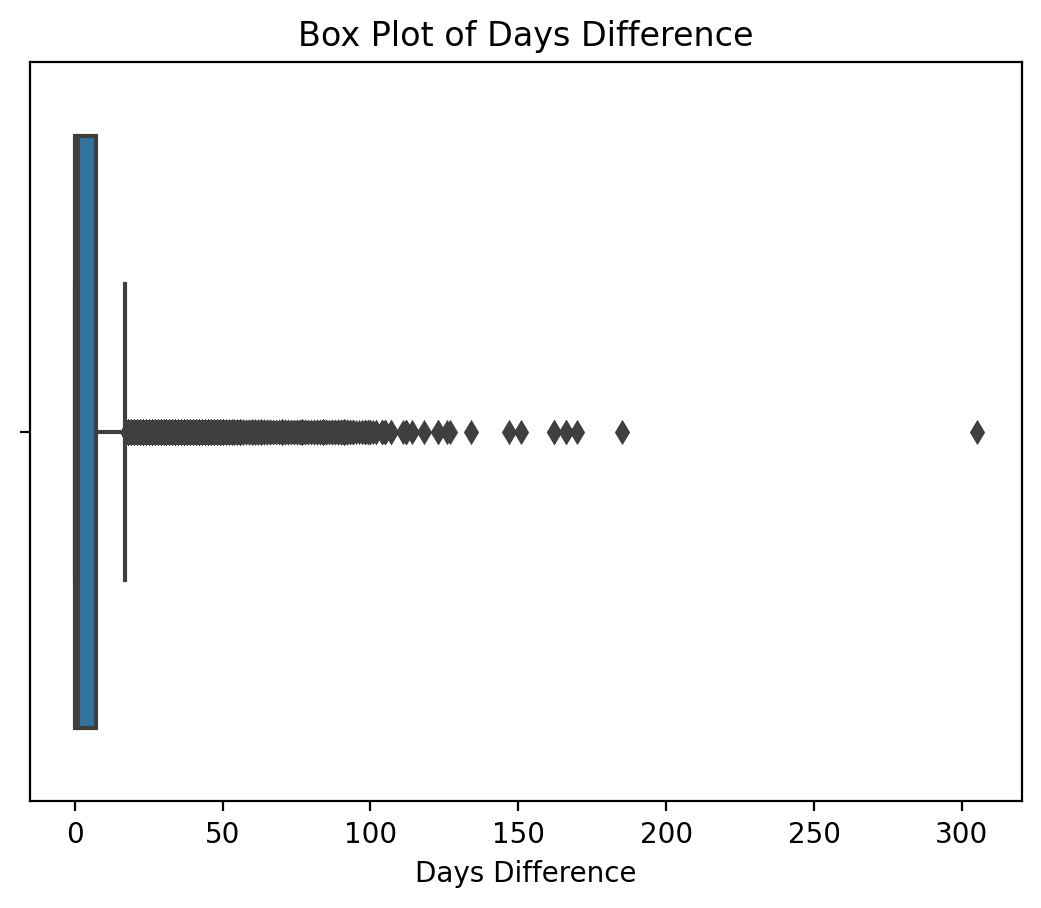

In [16]:
# days until appointment function
def calculate_days_difference(data):
    # Convert the date columns to datetime objects
    data['Appointment booked date'] = pd.to_datetime(data['Appointment booked date'], format='%d-%b-%y')
    data['Appointment date'] = pd.to_datetime(data['Appointment date'], format='%d-%b-%y')

    # Calculate the difference in days and create a new column
    data['Days Difference'] = (data['Appointment date'] - data['Appointment booked date']).dt.days
    
    # Drop rows where 'Days Difference' is negative
    data = data[data['Days Difference'] >= 0]

    return data

# Call the function to add the 'Days Difference' column to your DataFrame
tdata = calculate_days_difference(tdata)

print(tdata['Days Difference'].describe())

plt.hist(tdata['Days Difference'], bins=20, edgecolor='k')
plt.xlabel('Days Difference')
plt.ylabel('Frequency')
plt.title('Distribution of Days Difference')
plt.show()

sns.boxplot(x=tdata['Days Difference'])
plt.xlabel('Days Difference')
plt.title('Box Plot of Days Difference')
plt.show()

In [12]:
def process_dataframe(df):
    # Check if HEIGHT and WEIGHT columns have been cleaned
    if not df['WEIGHT'].dtype == float:
        # Clean the WEIGHT column
        def clean_weight(weight_str):
            if isinstance(weight_str, str):
                match = re.search(r'\d+', weight_str)
                if match:
                    return float(match.group())
            return None

        df['WEIGHT'] = df['WEIGHT'].apply(clean_weight)

    if not df['HEIGHT'].dtype == float:
        # Clean the HEIGHT column
        def clean_height(height_str):
            if isinstance(height_str, str):
                match = re.search(r'\d+\.\d+', height_str)
                if match:
                    return float(match.group())
            return None

        df['HEIGHT'] = df['HEIGHT'].apply(clean_height)

    # Calculate BMI
    df['BMI'] = (df['WEIGHT'] / (df['HEIGHT'] ** 2))

    # Create the 'depr' column
    df['depr'] = df['Depression'].apply(lambda x: 1 if isinstance(x, str) and re.search(r'\S', x) else 0)

    return df

# Process the DataFrame using the function
ecs = process_dataframe(ecs)

# Print the updated DataFrame
print(ecs)

      NHS number  WEIGHT  HEIGHT Depression    SMI         BP HBA1C     DM  \
0     3369850591     NaN     NaN                          NaN   NaN          
1     3380959626    65.0    1.73                     118 / 70   NaN          
2     3385770297     NaN     NaN                          NaN   NaN          
3     3487638886    78.0    1.86                     128 / 68   NaN          
4     3662712466    95.0    1.83                     121 / 75   NaN          
...          ...     ...     ...        ...    ...        ...   ...    ...   
9654  7316268751     NaN     NaN                          NaN   NaN          
9655  7316327731     2.0     NaN                          NaN   NaN          
9656  7316476796     NaN     NaN                          NaN   NaN          
9657  9990110662    85.0     NaN                    175 / 100   NaN  X40J5   
9658  9990254141    60.0    1.57                     100 / 70   NaN          

        IHD        BMI  depr  
0                  NaN     0  
1

In [7]:
import math

def haversine_distance(surgery_prefix, lat2, lon2):
    R = 6371.0  # Radius of the Earth in kilometers

    if surgery_prefix == 'ECS':
        lat1, lon1 = 51.488721, -0.191873
    elif surgery_prefix == 'SMW':
        lat1, lon1 = 51.494474, -0.181931
    elif surgery_prefix == 'TCP':
        lat1, lon1 = 51.48459, -0.171887
    elif surgery_prefix == 'HPVM':
        lat1, lon1 = 51.48459, -0.171887
    elif surgery_prefix == 'KMC':
        lat1, lon1 = 51.49807, -0.159918
    elif surgery_prefix == 'TGP':
        lat1, lon1 = 51.482652, -0.178066


    # Convert degrees to radians
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)

    # Differences
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    # Haversine formula
    a = math.sin(dlat / 2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    distance = R * c
    return distance  # in kilometers

In [8]:
def make_global_disease_register(surgery_list = ['ECS', 'TCP', 'TGP', 'SMW', 'KMC', 'HPVM']):
    print('=== Preparing Global Disease Register + IMD2023 info ======================================')

    disease_register = []
    for surgery in surgery_list:
        register_path = f'{RAW_DATA}{surgery}/{surgery}'

        idnhs = pd.read_excel(f'{register_path}_NHS_PTID.xlsx', dtype='str')
        idnhs.dropna(inplace=True)
        frail = pd.read_csv(f'{register_path}_FRAILTY.csv', dtype='str')
        dep = pd.read_csv(f'{register_path}_DEPRESSION.csv', dtype='str')
        obesity = pd.read_csv(f'{register_path}_OBESITY.csv', dtype='str')
        chd = pd.read_csv(f'{register_path}_IHD.csv', dtype='str')
        dm = pd.read_csv(f'{register_path}_DM.csv', dtype='str')
        hpt = pd.read_csv(f'{register_path}_HPT.csv', dtype='str')
        ndhg = pd.read_csv(f'{register_path}_NDHG.csv', dtype='str')
        smi = pd.read_csv(f'{register_path}_SMI.csv', dtype='str')

        ptid = idnhs.merge(frail, how='left', on='NHS number')
        ptid = ptid.drop(columns='NHS number')

        register = (ptid.merge(dep, how='left', on='Patient ID')
                    .merge(obesity, how='left', on='Patient ID')
                    .merge(chd, how='left', on='Patient ID')
                    .merge(dm, how='left', on='Patient ID')
                    .merge(hpt, how='left', on='Patient ID')
                    .merge(ndhg, how='left', on='Patient ID')
                    .merge(smi, how='left', on='Patient ID')
                    .fillna(0)
                    )
        print(f'💊 {surgery} Disease Register completed')
        # Add IMD and distance from station
        imd = pd.read_csv(IMD_DATA)

        full_register = register.merge(imd, how='left', on='Postcode')
        print(f'🔸 {surgery} IMD2023')
        full_register['distance_from_surg'] = full_register.apply(lambda row: haversine_distance(surgery, row['Latitude'], row['Longitude']), axis=1)
        disease_register.append(full_register)

    global_register = pd.concat(disease_register, axis=0, ignore_index=True)
    print(f"🦠 Concat Registers into ONE REGISTER")
    
    global_register.dropna(inplace=True)
    print(f'❌ Dropped NaN')
    
    output_path = f'{OUTPUT_DATA}global_disease_register.csv'
    global_register.to_csv(output_path, index=False)
    print(f'✅ Global Disease Register Saved to output-data: {global_register.shape}')
    print()
    return global_register

In [9]:
disease_register = make_global_disease_register()

=== Preparing Global Disease Register + IMD2023 info ======================================


FileNotFoundError: [Errno 2] No such file or directory: '/home/mowgley/code/janduplessis883/data-showup/data/raw-data/ECS/ECS_NHS_PTID.xlsx'